In [1]:
#!/usr/bin/env python
# coding: utf-8

import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import shapely
from shapely.geometry import Polygon
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import leaves_list
from shapely.ops import unary_union


In [2]:
def draw_point(pc,txt):
#     plt.figure(num=3, figsize=(5, 5))
    X, Y= pc
    plt.scatter(X, Y, c='b')
    plt.annotate(txt, pc, size=12)
#     plt.plot(X, Y, c='b')
#     plt.plot([X[-1],X[0]], [Y[-1],Y[0]], c='b')

    plt.axis('equal')
#     plt.axis('off')
#     plt.show()

def draw_polygon(pc):
    plt.figure(num=3, figsize=(5, 5))
    X, Y= pc[:, 0], pc[:,1]
#     plt.scatter(X, Y, c='b')
    plt.plot(X, Y, c='b')
    plt.plot([X[-1],X[0]], [Y[-1],Y[0]], c='b')

    plt.axis('equal')
    plt.axis('off')
#     plt.show()

def draw_polygon_box(pc):
    plt.figure(num=3, figsize=(5, 5))
    X, Y= pc[:, 0], pc[:,1]
#     plt.scatter(X, Y, c='b')
    plt.plot(X, Y, c='b')
    plt.plot([X[-1],X[0]], [Y[-1],Y[0]], c='b')
    
    poly = Polygon(pc)
    xy = poly.minimum_rotated_rectangle.exterior.coords.xy
    print(len(xy[0]))
    for i in range(len(xy[0])):
        plt.scatter(xy[0][i], xy[1][i], c='r')
        
    
    
    
    plt.axis('equal')
    plt.axis('off')
    

def draw_polygon_c(pc, txt, center, color):
    
    X, Y= pc[:, 0], pc[:,1]

    plt.plot(X, Y, c=color)
    plt.plot([X[-1],X[0]], [Y[-1],Y[0]], c=color)
    
    plt.annotate(txt, center, size=8)
#     plt.scatter(center[0], center[1], c='b')
    n = np.arange(len(pc))
    for i,txt in enumerate(n):
        plt.annotate(txt,(pc[i,0],pc[i,1]),size=8)
        
#     plt.axis('equal')
#     plt.axis('off')
#     plt.show()

def trans_index(polygon):
    min_index = np.argmin(polygon[:,0] + polygon[:,1])
    return np.vstack((polygon[min_index:],polygon[:min_index]))  

def trans_stroke(stroke):
#     stroke = stroke - stroke[0]
    stroke3 = np.zeros(stroke.shape)
    for i in range(len(stroke)):
        if(i == 0):
            stroke3[i,:2]=stroke[i,:2] - stroke[0,:2]
        else:
            stroke3[i,:2]=stroke[i,:2] - stroke[i-1,:2]
        stroke3[i,2] = stroke[i,2]
    return stroke3

def rotate_xy(p, sin, cos, center):
    x_ = (p[:,0:1]-center[:,0:1])*cos-(p[:,1:2]-center[:,1:2])*sin+center[:,0:1]
    y_ = (p[:,0:1]-center[:,0:1])*sin+(p[:,1:2]-center[:,1:2])*cos+center[:,1:2]
#     print(((p[:,0:1]-center[:,0:1])*cos).shape, cos.shape, x_.shape)
    return np.hstack((x_, y_))

def get_box(P, F):
    ld = np.hstack((P[:,0:1]-F[:,0:1]/2, P[:,1:2]-F[:,1:2]/2))
    rd = np.hstack((P[:,0:1]+F[:,0:1]/2, P[:,1:2]-F[:,1:2]/2))
    ru = np.hstack((P[:,0:1]+F[:,0:1]/2, P[:,1:2]+F[:,1:2]/2))
    lu = np.hstack((P[:,0:1]-F[:,0:1]/2, P[:,1:2]+F[:,1:2]/2))
    # box = np.hstack((ld, rd, ru, lu)).reshape(len(P), -1, 2)
    sinO = F[:,2:3]
    cosO = np.cos(np.arcsin(F[:,2:3]))

    ld_r = rotate_xy(ld, sinO, cosO, P)
    rd_r = rotate_xy(rd, sinO, cosO, P)
    ru_r = rotate_xy(ru, sinO, cosO, P)
    lu_r = rotate_xy(lu, sinO, cosO, P)
    if(len(P)>0):
        box_r = np.hstack((ld_r, rd_r, ru_r, lu_r)).reshape(len(P), -1, 2)
    else:
        box_r = []
    return box_r
#     plt.figure(figsize=(15, 15))
#     for i, p in enumerate(box_r):    
#         draw_polygon_c(p, i, P[i,:2],'r')
# #     plt.savefig('ab.jpg')
#     plt.show()

def draw_polygon_c(pc, txt, center, color):
    
    X, Y= pc[:, 0], pc[:,1]
    plt.plot(X, Y, c=color)
    plt.plot([X[-1],X[0]], [Y[-1],Y[0]], c=color)
    plt.annotate(txt, center, size=8)
#     plt.scatter(center[0], center[1], c='b')
#     n = np.arange(len(pc))
#     for i,txt in enumerate(n):
#         plt.annotate(txt,(pc[i,0],pc[i,1]),size=8)
        
    plt.axis('equal')
    my_x_ticks = np.arange(-0.2, 1.4, 0.2)
    my_y_ticks = np.arange(-0.2, 1.4, 0.2)
    plt.xticks(my_x_ticks)
    plt.yticks(my_y_ticks)
#     plt.axis('off')
#     plt.show()

def draw_box(box, txt, center):
#     print(box.shape)
    for i, p in enumerate(box):
#         print(p.shape)
        draw_polygon_c(p, txt[i], center[i], 'r')

def plot_boxes(samples, label, center, n, m, save=False, savename='pclouds'):
    fig = plt.figure(figsize=(5*m,5*n))
    fig.set_tight_layout(True)
    for i in range(n):
        for j in range(m):
            idx = i * m + j
            ax = fig.add_subplot(n, m, idx+1)
#             print(idx)
            draw_box(samples[idx], label[idx], center[idx])  
    if save:
        plt.savefig(savename)

    plt.show()

In [3]:
def cal_dis(p, q):
    return np.sqrt((p[0] - q[0])*(p[0] - q[0]) + (p[1] - q[1])*(p[1] - q[1]))

def rotate_xy(p, sin, cos, center):
    x_ = (p[:,0:1]-center[:,0:1])*cos-(p[:,1:2]-center[:,1:2])*sin+center[:,0:1]
    y_ = (p[:,0:1]-center[:,0:1])*sin+(p[:,1:2]-center[:,1:2])*cos+center[:,1:2]
#     print(((p[:,0:1]-center[:,0:1])*cos).shape, cos.shape, x_.shape)
    return np.hstack((x_, y_))

def get_center_width_height_angle(index_sort, polygon_list_sort, N):
    P = np.zeros((N, 2))
    Feature = np.zeros((N, 3))
    n = 0
    j = 0 
    box_list = []
    while(n<N):
        near_poly = index_sort[j]
        tmp_near_polygon = polygon_list_sort[near_poly]
        poly = Polygon(tmp_near_polygon)
        xy = poly.minimum_rotated_rectangle.exterior.coords.xy
        p_box = np.array(xy).T
        p_box = trans_index(p_box[:4])
        tmp_poly_box = Polygon(p_box)
    #     print(tmp_poly_box)
        if(len(box_list)):
            flag = True
            for p in box_list:
                p = Polygon(p)
                flag = flag & (tmp_poly_box.intersection(p).area<1e-2)
                if(not flag):
                    break
    #             if(tmp_poly_box.intersection(p).area):
    #                 print(j, tmp_poly_box.intersection(p).area)
            if(flag):
                box_list.append(p_box)
                n = n +1
        else:
            box_list.append(p_box)
            n = n +1
        j = j +1

    polygons = [Polygon(p) for p in box_list]
    poly = unary_union(polygons)
    min_x, min_y, max_x, max_y = poly.bounds
    box_norm_list = (np.array(box_list) - [min_x, min_y])/([max_x-min_x, max_y-min_y])

    for i, p in enumerate(box_norm_list):
        center = np.mean(p, axis=0)
        width = cal_dis(p[0], p[1])
        height = cal_dis(p[1], p[2])
        angle = (p[1] - p[0])[1]/cal_dis(p[0], p[1])
        
        P[i] = center
    #         Feature[i] = [center[0], center[1], width, height, angle]
        Feature[i] = [width, height, angle]
    return P, Feature, box_norm_list

In [4]:
data_folder = 'Data/Manhattan_polygon2_45847.pickle'
with open(data_folder, 'rb') as filename:
    polygon_list = pickle.load(filename)

center_mean = np.zeros((len(polygon_list), 2))
for i in range(len(polygon_list)):
    center_mean[i] = np.mean(polygon_list[i], axis=0)[:2]
    polygon_list[i] = polygon_list[i][:,:2]
    
index = np.argsort(center_mean[:,0] + center_mean[:,1])
polygon_list_sort = np.array(polygon_list)[index]
center_mean_sort = center_mean[index]
len(center_mean_sort)

train_index = random.sample(range(len(center_mean_sort)), 45000)
Z_list = []
P_list = []
Feature_list = []
Box_list = []
N = 32
n = 0
for i in range(len(train_index)):
# for i in range(1):
    if(i%1000==0):
        print(i)
    t = train_index[i]    
    index_sort = np.argsort(np.sum(abs(center_mean_sort - center_mean_sort[t]),1))
    P, Feature, Box = get_center_width_height_angle(index_sort, polygon_list_sort, N)
    Z = hierarchy.linkage(P, 'ward')
    Z_list.append(Z)
    P_list.append(P)
    Feature_list.append(Feature)
    Box_list.append(Box)

45847

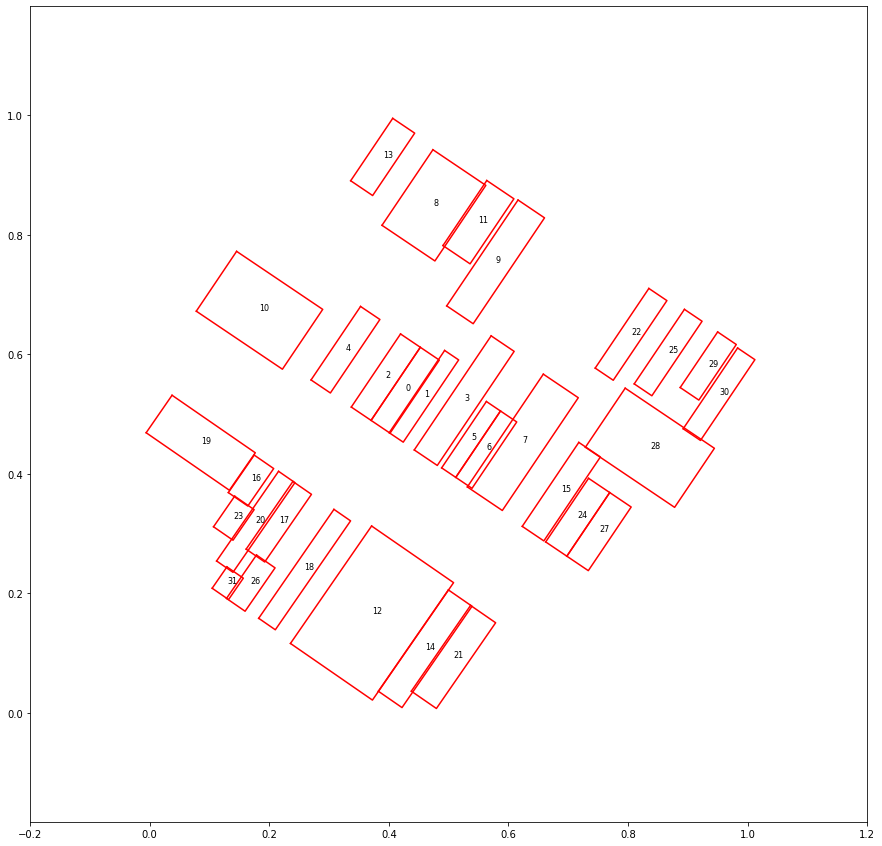

In [6]:
i = 1
node = P_list[i]
P = P_list[i]
Feature = Feature_list[i]
boxes = get_box(P_list[i], Feature_list[i])

plt.figure(figsize=(15, 15))
for i, p in enumerate(boxes):    
    draw_polygon_c(p, i, node[i],'r')
plt.show()

In [7]:
sinO = Feature[:,2:3]
cosO = np.cos(np.arcsin(Feature[:,2:3]))
ld = np.hstack((P[:,0:1]-Feature[:,0:1]/2, P[:,1:2]-Feature[:,1:2]/2))
rd = np.hstack((P[:,0:1]+Feature[:,0:1]/2, P[:,1:2]-Feature[:,1:2]/2))
ru = np.hstack((P[:,0:1]+Feature[:,0:1]/2, P[:,1:2]+Feature[:,1:2]/2))
lu = np.hstack((P[:,0:1]-Feature[:,0:1]/2, P[:,1:2]+Feature[:,1:2]/2))
box = np.hstack((ld, rd, ru, lu)).reshape(len(P), -1, 2)

ld_r = rotate_xy(ld, sinO, cosO, P)
rd_r = rotate_xy(rd, sinO, cosO, P)
ru_r = rotate_xy(ru, sinO, cosO, P)
lu_r = rotate_xy(lu, sinO, cosO, P)
box_r = np.hstack((ld_r, rd_r, ru_r, lu_r)).reshape(len(P), -1, 2)

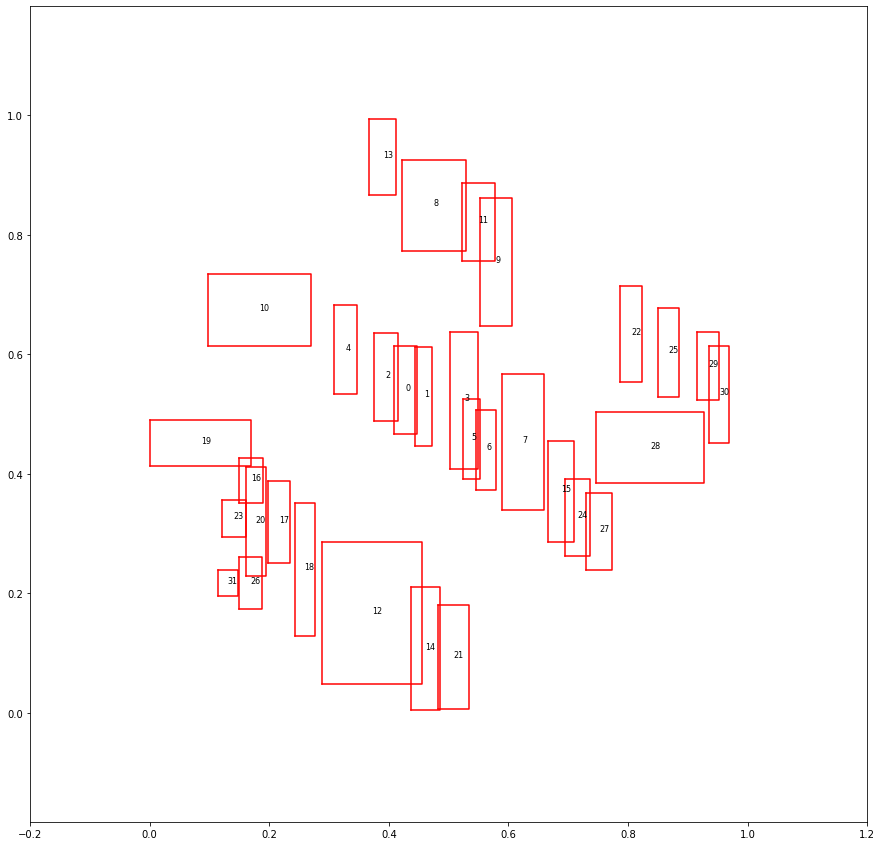

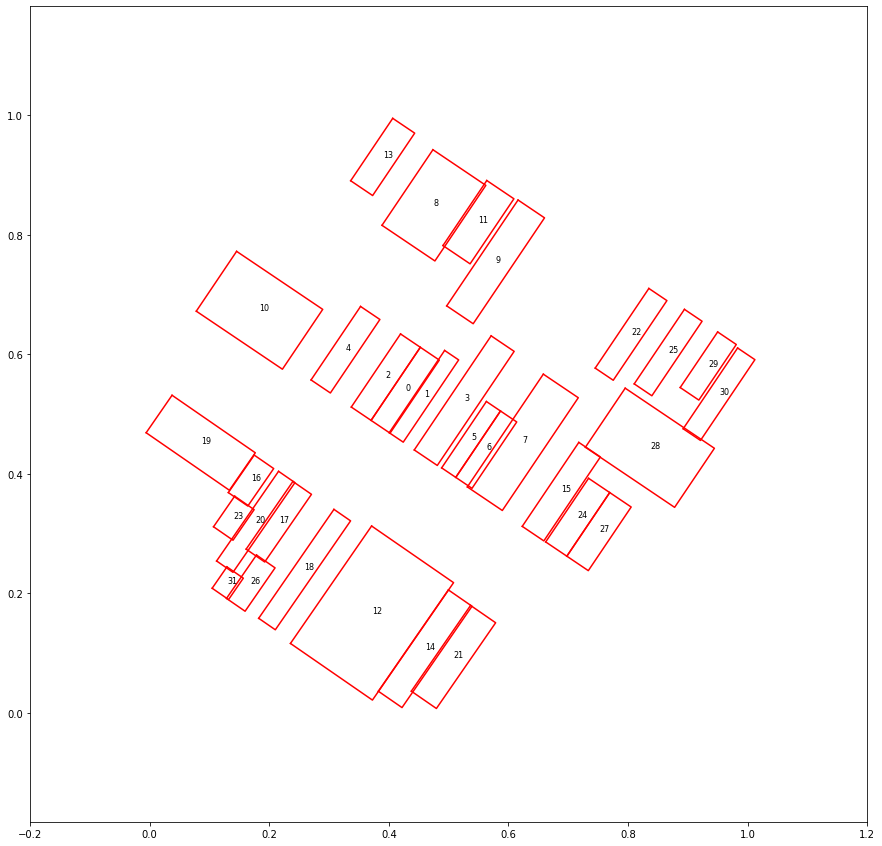

In [8]:
plt.figure(figsize=(15, 15))
for i, p in enumerate(box):    
    draw_polygon_c(p, i, P[i],'r')
plt.show()

plt.figure(figsize=(15, 15))
for i, p in enumerate(box_r):    
    draw_polygon_c(p, i, P[i],'r')
plt.show()

In [9]:
# a = Polygon(box_r[29])
# b = Polygon(box_r[35])
# a.intersection(b).area<1e-6

In [10]:
def get_father_Feature(tmp_child, P, Feature):
    boxes = get_box(P[tmp_child], Feature[tmp_child])
    polygons = [Polygon(p) for p in boxes]
    poly = unary_union(polygons)
    xy = poly.minimum_rotated_rectangle.exterior.coords.xy
    p_box = np.array(xy).T
    p = trans_index(p_box[:4])
    width = cal_dis(p[0], p[1])
    height = cal_dis(p[1], p[2])
    angle = (p[1] - p[0])[1]/cal_dis(p[0], p[1])
    return [width, height, angle]

In [11]:
Node_XYSF_re = []
Node_XYSF_ab = []
I_List = []
for n in range(len(Z_list)):
# for n in range(1):
    if(n%1000==0):
        print(n)
    linkage = Z_list[n]
    node = P_list[n]
    leaf_node = P_list[n]
    P = P_list[n]
    Feature = Feature_list[n]
#     print(n)
    for i in range(len(linkage)):
        new_node = np.mean(node[linkage[i,0:2].astype('int8')],axis=0)
        node = np.vstack((node,new_node))
        new_Feature = get_father_Feature(linkage[i,0:2].astype('int8'), node, Feature)
        Feature = np.vstack((Feature, new_Feature))
        
    label = np.unique(linkage[:,3])

    child_list = [[] for _ in range(len(node))]
    f_list = np.zeros(len(node))
    s_list = np.zeros(len(node))
    I_list = []
    for k in range(len(label)):
        index = (linkage[:,3] == label[k])
        child_node = linkage[index,:2]
        father_node = np.arange(len(linkage))[index]+len(leaf_node)
        f_list[child_node[:,0].astype('int32')] = father_node
        f_list[child_node[:,1].astype('int32')] = father_node
        father_node = father_node.reshape(len(father_node),1)
        
        left_node_x = node[(child_node[:,0]).astype('int32')][:,0]
        father_node_x = node[(father_node[:,0]).astype('int32')][:,0]

        swap_index = np.arange(len(father_node_x))[left_node_x > father_node_x]
        if(len(swap_index)):
            tmp_left_idx = child_node[swap_index,0]
            tmp_right_idx = child_node[swap_index,1]
            child_node[swap_index,0] = tmp_right_idx
            child_node[swap_index,1] = tmp_left_idx
            
        I = np.hstack((child_node,father_node))
        I_list.append(I)

    s_list = s_list.reshape(len(s_list),1)
#     node_n = (node - node[f_list.astype('int32')])/s_list[f_list.astype('int32')]
    node_n = (node - node[f_list.astype('int32')])/ Feature[f_list.astype('int32'),:2]
    node_n[-1] =  node[-1]
    
    Feature_n_wh = Feature[:,:2] / Feature[f_list.astype('int32'),:2]        
    Feature_n_a = np.arcsin(Feature[:,2:3]) - np.arcsin(Feature[f_list.astype('int32'),2:3])
    Feature_n = np.hstack((Feature_n_wh, Feature_n_a))
    Feature_n[-1] = Feature[-1]
    Feature_n[-1,2:3] = np.arcsin(Feature_n[-1,2:3])
#     print(max(Feature_n_a),min(Feature_n_a))
    node_ab_s_f = np.hstack((node, Feature))
    node_re_s_f = np.hstack((node_n, Feature_n))
    
#     if(np.sum(node_n>1.0000)):
#         print(node_n, node_n[node_n>1.000])
#     print(f_list)
    Node_XYSF_ab.append(node_ab_s_f)
    Node_XYSF_re.append(node_re_s_f)
    I_List.append(I_list)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000


In [ ]:
Z_list[0]

In [ ]:
I_List[0][0][-100:]

In [ ]:
len(I_List)

In [ ]:
I_List[0]

In [ ]:
Feature[-1,2:3]

In [ ]:
np.arcsin(Feature[-1,2:3])

In [ ]:
np.set_printoptions(suppress=True)
[(i,node_re_s_f[i]) for i in range(len(node_re_s_f))]

In [12]:
Batch_size = 50

In [13]:
Node_XYS = Node_XYSF_ab
batch_xys_ab = []
batch_I = []
for i in range(len(Node_XYS)//Batch_size):
# for i in range(1):
    for j in range(Batch_size):
        idx= i*Batch_size+j

        if(j == 0):
            tmp_xys = Node_XYS[idx]
            tmp_I = I_List[idx]
        else:
            tmp_xys = np.vstack((tmp_xys, Node_XYS[idx]))
            
            max_len = max(len(tmp_I), len(I_List[idx]))
#             print(max_len)
            
            for k in range(max_len):
#                 print(k, len(tmp_I),len(I_List[idx]))
                if((k<len(tmp_I)) and (k<len(I_List[idx]))):
                    new_I = I_List[idx][k]+j*len(Node_XYS[idx])
                    tmp_I[k] = np.vstack((tmp_I[k],new_I))
                else:
                    if(k<len(I_List[idx])):
                        new_I = I_List[idx][k]+j*len(Node_XYS[idx])
                        tmp_I.append(new_I)
#                     else:
#                         print('www')
        
    batch_xys_ab.append(tmp_xys)
    batch_I.append(tmp_I)

In [14]:
max_len = 0
for i in range(len(batch_I)):
    if(max_len<len(batch_I[i])):
        max_len = len(batch_I[i])
print(max_len)
#     print(len(batch_I[i]))

14


In [15]:
Node_XYS = Node_XYSF_re
batch_xys_re = []
batch_I = []
for i in range(len(Node_XYS)//Batch_size):
# for i in range(1):
    for j in range(Batch_size):
        idx= i*Batch_size+j

        if(j == 0):
            tmp_xys = Node_XYS[idx]
            tmp_I = I_List[idx]
        else:
            tmp_xys = np.vstack((tmp_xys, Node_XYS[idx]))
            
            max_len = max(len(tmp_I), len(I_List[idx]))
#             print(max_len)
            
            for k in range(max_len):
#                 print(k, len(tmp_I),len(I_List[idx]))
                if((k<len(tmp_I)) and (k<len(I_List[idx]))):
                    new_I = I_List[idx][k]+j*len(Node_XYS[idx])
                    tmp_I[k] = np.vstack((tmp_I[k],new_I))
                else:
                    if(k<len(I_List[idx])):
                        new_I = I_List[idx][k]+j*len(Node_XYS[idx])
                        tmp_I.append(new_I)
#                     else:
#                         print('www')
        
    batch_xys_re.append(tmp_xys)
    batch_I.append(tmp_I)

In [ ]:
batch_I[0][0].shape

In [ ]:
batch_xys_re[0]

In [17]:
len(batch_xys_re)

900

In [ ]:
# filename = 'Tree_AE/Tree_2000_64_batch5_box_ab_new2_16.pickle'
# pfile = open(filename,'wb')
# pickle.dump((batch_xys_ab, batch_I), pfile, protocol=2)
# pfile.close()

In [ ]:
# filename = 'Tree_AE/Tree_2000_64_batch5_box_re_new2_64_2000.pickle'
# pfile = open(filename,'wb')
# pickle.dump((batch_xys_re, batch_I), pfile, protocol=2)
# pfile.close()

In [ ]:
# filename = 'Tree_AE/Tree_2000_64_batch5_box_re_new2_64_20000_batch50.pickle'
# pfile = open(filename,'wb')
# pickle.dump((batch_xys_re, batch_I), pfile, protocol=2)
# pfile.close()

In [16]:
filename = 'Tree_AE/Tree_2000_64_batch5_box_re_new2_32_45000_batch50.pickle'
pfile = open(filename,'wb')
pickle.dump((batch_xys_re, batch_I), pfile, protocol=2)
pfile.close()

In [ ]:
node_xys =batch_xys_ab[0]

In [ ]:
pen_state = np.zeros((node_xys.shape[0], 3))
pen_state[:,0] = 1
for i in range(5):
    pen_state[i*127:i*127+64]=np.array([0,1,0])
node_xys = np.hstack((node_xys, pen_state))

In [ ]:
pen_state

In [ ]:
node_xys[62:128]